In [1]:
# Install (optional) & Imports
# !pip install llama-index llama-index-multi-modal-llms-openai llama-index-embeddings-openai \
#     llama_index[clip] qdrant-client

import os
from pathlib import Path

from llama_index.core import (
    SimpleDirectoryReader,
    PromptTemplate,
    Settings,
)
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.clip import ClipEmbedding

In [2]:
# API Key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [3]:
# Embedding models
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
image_embed_model = ClipEmbedding()

In [4]:
# Load images
image_documents = SimpleDirectoryReader(
    "./input_images",
    required_exts=[".png", ".jpg", ".jpeg"],
).load_data()

print("Loaded images:", len(image_documents))
for d in image_documents:
    print(" -", d.metadata.get("file_path"))

Loaded images: 5
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/input_images/long_range_spec.png
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/input_images/model_y.png
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/input_images/performance_spec.png
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/input_images/price.png
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/input_images/real_wheel_spec.png


In [5]:
# Build multimodal index
index = MultiModalVectorStoreIndex.from_documents(
    image_documents,
    embed_model=Settings.embed_model,
    image_embed_model=image_embed_model,
)
print("Index built successfully.")

Index built successfully.


In [8]:
# Prepare multimodal LLM
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o-mini",
    max_new_tokens=1500,
)
print("OpenAI MultiModal LLM ready.")

OpenAI MultiModal LLM ready.


In [9]:
# Simple full-image reasoning example
resp = openai_mm_llm.complete(
    prompt="これらの画像に基づいて、自動車のバリエーションと違いを日本語で説明してください。",
    image_documents=image_documents,
)
print(resp)

これらの画像に基づいて、自動車のバリエーションと違いについて説明します。

### モデルのバリエーション
1. **バッテリーと航続距離**
   - **ロングレンジAWD**: 航続距離は497 km（EPA推定）で、長距離走行に適しています。
   - **リアホイールドライブ**: 航続距離は394 km（EPA推定）で、短距離向けです。

2. **加速性能**
   - **ロングレンジAWD**: 0-100 km/hの加速は5.0秒。
   - **リアホイールドライブ**: 0-100 km/hの加速は6.9秒。

3. **重量**
   - **ロングレンジAWD**: 重量は1,979 kg。
   - **リアホイールドライブ**: 重量は1,909 kg。

4. **最大積載量**
   - 両モデルとも最大積載量は2,158リットルですが、ロングレンジAWDの方が若干の余裕があります。

5. **最高速度**
   - 両モデルとも最高速度は217 km/hで同じです。

6. **ホイールサイズ**
   - **ロングレンジAWD**: 19インチまたは20インチのホイール。
   - **リアホイールドライブ**: 19インチまたは21インチのホイール。

### その他の特徴
- **ドライブシステム**: 両モデルともデュアルモーターAWD（全輪駆動）ですが、リアホイールドライブは後輪駆動です。
- **ディスプレイ**: どちらのモデルも15インチのタッチスクリーンを搭載しています。
- **充電システム**: 充電能力はロングレンジAWDが250 kW、リアホイールドライブが170 kWです。

### 結論
ロングレンジAWDは長距離走行や加速性能に優れ、リアホイールドライブはコストパフォーマンスが良い選択肢です。用途に応じて選ぶことが重要です。


In [10]:
# Build QA template + QueryEngine
qa_template_str = (
    "あなたは車のスペックに詳しいアシスタントです。\n"
    "与えられた画像の内容に基づいて答えてください。\n"
    "不確実な内容は「推測」と明示してください。\n"
    "\n"
    "質問: {query_str}\n"
    "回答（日本語）:"
)

qa_template = PromptTemplate(qa_template_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm,
    image_qa_template=qa_template,
)

print("QueryEngine ready.")

QueryEngine ready.


In [11]:
# Image-based RAG query
query_str = "この画像と似たスペックの車を教えてください。"

response = query_engine.image_query(
    "./input_images/performance_spec.png",
    query_str,
)

print(response)

画像の内容に基づいて、以下のスペックを持つ車を推測します。

1. **テスラ モデル Y ロングレンジ AWD**
   - バッテリー: ロングレンジ
   - 加速: 0-100 km/h 5.0秒
   - 航続距離: 約497 km
   - 最高速度: 217 km/h
   - ドライブ: デュアルモーター全輪駆動
   - 最大積載量: 2,158リットル
   - シート数: 最大5人
   - ホイールサイズ: 19インチまたは20インチ

このようなスペックの車として、テスラ モデル Y ロングレンジ AWDが考えられます。


In [12]:
# Text-only query
response2 = query_engine.query("Tesla Model Y の各グレードの違いを教えてください。")
print(response2)

Tesla Model Yには主に以下の2つのグレードがあります。

1. **リアホイールドライブ (RWD)**:
   - **バッテリー**: スタンダードレンジ
   - **加速**: 0-100 km/hが6.9秒
   - **航続距離**: 約394 km（EPA推定）
   - **最高速度**: 217 km/h
   - **重量**: 1,909 kg
   - **最大積載量**: 2,158リットル
   - **座席数**: 最大5人
   - **ホイールサイズ**: 19インチまたは20インチ

2. **ロングレンジAWD**:
   - **バッテリー**: ロングレンジ
   - **加速**: 0-100 km/hが6.9秒
   - **航続距離**: 詳細は記載されていませんが、通常はRWDよりも長い
   - **最高速度**: 217 km/h
   - **重量**: 詳細は記載されていませんが、通常はRWDよりも重い
   - **最大積載量**: 詳細は記載されていませんが、通常はRWDと同等またはそれ以上
   - **座席数**: 最大5人
   - **ホイールサイズ**: 19インチまたは20インチ

各グレードの詳細は、性能や航続距離、バッテリーの種類に基づいて異なります。


Loaded mixed_wiki images: 145
Top Similar Images from mixed_wiki:
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/mixed_wiki/59.jpg (score: 1.0000)
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/mixed_wiki/56.jpg (score: 0.9203)
 - /Users/yeyeaipaobu/Desktop/SDS_MLLM_RAG/mixed_wiki/63.jpg (score: 0.8738)


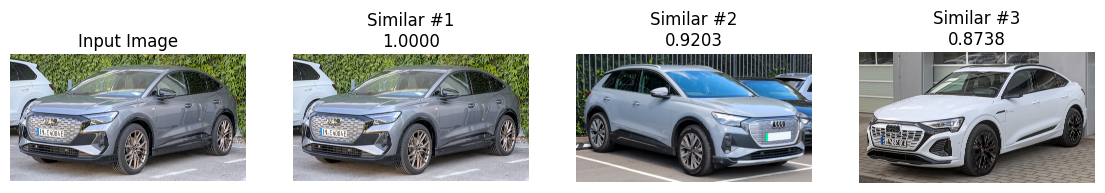

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. mixed_wiki の画像を読み込む ---
wiki_docs = SimpleDirectoryReader(
    "./mixed_wiki",
    required_exts=[".png", ".jpg", ".jpeg"]
).load_data()

print("Loaded mixed_wiki images:", len(wiki_docs))

wiki_index = MultiModalVectorStoreIndex.from_documents(
    wiki_docs,
    embed_model=Settings.embed_model,        # text embedding
    image_embed_model=image_embed_model,     # CLIP
)

# --- 2. Similar image search ---
input_image_path = "./input_images/model_y.png"
#input_image_path = "./input_images/performance_spec.png"
#input_image_path = "./mixed_wiki/59.jpg"

wiki_retriever = wiki_index.as_retriever(
    similarity_top_k=3,
    image_similarity_top_k=3,
)

similar_nodes = wiki_retriever.image_to_image_retrieve(input_image_path)

# --- 3. 結果表示 ---
print("Top Similar Images from mixed_wiki:")
results = []
for n in similar_nodes:
    fp = n.node.metadata.get("file_path")
    score = n.score
    results.append((fp, score))
    print(f" - {fp} (score: {score:.4f})")

# --- 4. 画像を並べて可視化 ---
plt.figure(figsize=(14, 4))

# 入力画像
plt.subplot(1, 4, 1)
plt.imshow(Image.open(input_image_path))
plt.title("Input Image")
plt.axis("off")

# 類似画像
for i, (fp, score) in enumerate(results[:3], start=2):
    plt.subplot(1, 4, i)
    plt.imshow(Image.open(fp))
    plt.title(f"Similar #{i-1}\n{score:.4f}")
    plt.axis("off")

plt.show()
